# Material de aula - Redes Neurais e Deep Learning


## <center> Exercício 3 - LSTM: Previsão de variação de preço em ações </center>

Instruções para a realização desta atividade:

1. Faça o download deste notebook Jupyter para sua estação de trabalho
2. Realize as atividades solicitadas dentro do notebook, nos espaços apropriados e indicados
3. Salve o notebook no seguinte padrão: <nome_sobrenome_RA>.ipynb (por exemplo: **rodrigo_caropreso_123456.ipynb ** )
4. Envie o notebook com a atividade realizada na sala de aula da disciplina (Google Classroom)

** DATA DE ENTREGA DESTA ATIVIDADE: 03/08/2019 **

** VALOR DESTA ATIVIDADE: 3,0 pontos **

In [47]:
#CÉLULA KE-LIB-01
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# <center> Atividade 1 - LSTM com 1 camada oculta </center>

### Vamos construir uma rede recorrente do tipo LSTM para examinar dados textuais a fim de prever o sentimento (positivo ou negativo) de um comentário sobre um dado filme.

### A LSTM tem a seguinte topologia:

 - A camada de memória (contexto) da rede possui 50 células.
 - A camada de saída terá um neurônio para realizar a previsão
 - A função de ativação do neurônio de saída dependerá dos procedimentos a serem realizados na atividade
 
 Dados adaptados de: 
 - https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
 - https://www.kaggle.com/pablocastilla/predict-stock-prices-with-lstm
 - https://www.udemy.com/tensorflow-machine-learning-deep-learning-python

## Dataset obtido do yahoo finanças, período de Janeiro de 2013 a Janeiro de 2018. 

### O objetivo é utilizar uma rede LSTM para, após a leitura de dados de 30 dias sobre os preços, fazer a previsão do preço para o próximo dia.

### É necessário fazer a comparação para identificar o acerto da rede. 

- https://finance.yahoo.com/
    
### Colunas do data set:

- Date: Data de abertura do pregão
- Open: Preço da ação no momento de abertura
- High: Valor máximo atingido pelo preço da ação no dia
- Low: Valor mínimo da ação atingido no dia
- Close: Valor da ação no momento do fechamento
- Adj Close: Valor da ação ajustado após o fechamento, levando em conta variáveis econômicas, inclusive os dividendos
- Volume: volume de ações negociado na data


### Inicialização dos parâmetros. A inicialização fixa permite que os resultados possam ser reproduzidos de forma sistemática para melhorar as análises.

In [48]:
#CÉLULA KE-LIB-02
np.random.seed(1)
tf.set_random_seed(1)

## 1.1. Instruções:

- Faça a carga do dataset através do método
        
        pd.read_csv('petr4.csv')

In [49]:
#CÉLULA KE-LIB-03
#IMPLEMENTE O CÓDIGO AQUI 
dfPetr4 = pd.read_csv('petr4.csv', index_col='Date', parse_dates=True)

## 1.2. Instruções:

- Elimine as linhas inválidas com o comando 'dropna' do pandas

In [50]:
#CÉLULA KE-LIB-04
#IMPLEMENTE O CÓDIGO AQUI 
print('antes:',dfPetr4.shape)
dfPetr4 = dfPetr4.dropna()
print('depois:',dfPetr4.shape)

antes: (1262, 6)
depois: (1259, 6)


## 1.3. Instruções:

- Crie uma variável *openValues* contendo apenas os valores referentes ao preço de abertura da ação (coluna *'Open'*)
- Não esqueça de verificar o formato do array, use reshape se necessário, o array deve ser (n x 1)
- Plote um gráfico do vetor criado para visualizar a evolução do preço ao longo do tempo

<class 'numpy.ndarray'>
(1259, 1)


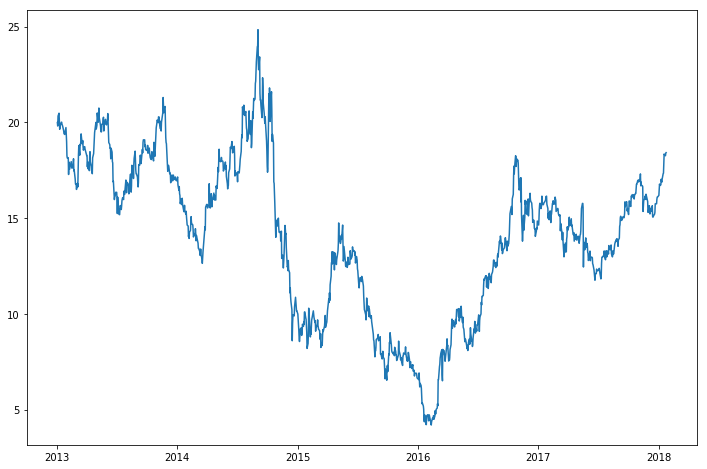

In [51]:
#CÉLULA KE-LIB-05
#IMPLEMENTE O CÓDIGO AQUI 
openValues = dfPetr4.iloc[:,1:2].values
openValuesGraf = dfPetr4.Open.T
print(type(openValues))
print(openValues.shape)

plt.figure(figsize=(12,8))
plt.plot(openValuesGraf)

In [52]:
openValues.shape


(1259, 1)

## Construindo a Topologia da Rede

## 1.4. Instruções:

- Faça a separação dos dados em conjuntos de treinamento e teste. A utilização de normalização pode ser considerada opcional nesta atividade.

- No entanto, você pode tentar realizar a atividade com e sem normalização, comparando os resultados

- Se for utilizar normalização, deve ser importada a biblioteca MinMaxScaler:

        from sklearn.preprocessing import MinMaxScaler

In [53]:
dfPetr4.head()
from sklearn.preprocessing import MinMaxScaler

In [54]:
#CÉLULA KE-LIB-06
#IMPLEMENTE O CÓDIGO AQUI (1 linha)
from sklearn.model_selection import train_test_split
y = dfPetr4.Close

X = dfPetr4.iloc[:,0:3]

X.shape
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


(1259, 3)

## 1.5. Instruções:

- Se for utilizar normalização, defina o domínio de normalização, abaixo segue um exemplo de normalização entre [-1, 1]

        scaler = MinMaxScaler(feature_range=(-1,1))
        scaler = scaler.fit(openValues)
        openValuesScaled = scaler.transform(openValues)
    
**NOTA:** observe que ao realizar a normalização no dataset inicial, todas as demais transformações já levarão em conta dados normalizados. Entretanto, NOVOS dados deverão ser normalizados antes de serem validados pela rede.

In [55]:
#CÉLULA KE-LIB-07
#IMPLEMENTE O CÓDIGO AQUI
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(openValues)
openValuesScaled = scaler.transform(openValues)
openValuesScaled.shape
openValuesScaled[1230]

array([0.07028599])

## 1.6. Instruções:

- Faça o janelamento dos dados de treinamento, para o treinamento supervisionado.

Como o problema trata de uma série temporal, é necessário realizar o 'janelamento' dos dados, ou seja:

- Para um dado tamanho da camada de contexto da rede (30 time_steps, por exemplo, ou 30 dias a serem levados em conta para realizar a previsão do próximo valor), é necessário criar uma amostra de entrada na seguinte forma:

  1. se x é o dataset com todos os valores da serie temporal, por exemplo, 1260 valores, as duas primeiras amostras serão:
   
         X_train[0] = [x(0),  x(1),  x(2), ...,  x(29)] e a saída correspondente será y_train[0] = x(30)       
         X_train[1] = [x(30), x(31), x(32), ..., x(59)] e a saída correspondente será y_train[1] = x(60) 
         e assim por diante.
       
    Desta forma, a previsão de valores continua sendo de um dia, baseada nos 30 dias anteriores, porém o valor de saída é apenas um valor unico e neste caso, você deverá deixar o parâmetro **return_sequences=False** na especificação da camada LSTM.
       
  2. outra forma de montar o dataset é fazer tanto a amostra de entrada quanto a de saída terem a mesma dimensão temporal:

         X_train[0] = [x(0),  x(1),  x(2), ...,  x(29)] e a saída será y_train[0] = [x(1),  x(2),  x(3), ...,  x(30)]
         X_train[1] = [x(30), x(31), x(32), ..., x(59)] e a saída será y_train[1] = [x(31), x(32), x(33), ..., x(60)] 
         e assim por diante.
    
    Desta forma, a previsão de valores continua sendo de um dia (note que a saída está deslocada em 01 unidade em relação à entrada). E neste caso, você deverá deixar o parâmetro **return_sequences=True** na especificação da camada LSTM.
   
  3. a rede LSTM exige, por design, receber um tensor com 3 dimensoes [batch_size, time_steps, num_features], onde:

    - batch_size representa o tamanho do grupo de batch (ou seja, quantas amostras serão exibidas antes de atualizar os pesos);
    - time_steps é o tamanho da camada de contexto (no caso, 30);
    - num_features é o numero de atributos que a amostra possui (no caso, utilizando somente a coluna 'Open', temos 1 feature. Se fôssemos utilizar outras colunas do dataset para compor a série temporal, seria necessário modificar este valor de acordo com a quantidade de colunas utilizada.)

In [56]:
#CÉLULA KE-LIB-08
from sklearn.model_selection import train_test_split
time_steps = 30
prediction = 1 #valor a ser previsto (um dia a frente)
num_features = 1 # numero de atributos usados

In [57]:
#CÉLULA KE-LIB-09
#Criação de conjunto de treinamento, utilizando o subitem 1 da descrição acima
#As variáveis de treinamento e teste deverão ser: X_train, X_test, y_train e y_test
#Se você fez a normalização usando MinMaxScaler, user a variável openValuesScaled. Caso contrario use a variavel openValues
#Este trecho de código abaixo, faz a montagem do dataset de treinamento conforme descrição do subitem 1

#A variável time steps corresponde a 30 dias da sequencia, e a variavel num_features corresponde a quantidade de atributos
#da entrada (1 valor, somente o campo 'Open')

X = openValuesScaled[0:(len(openValuesScaled) - (len(openValuesScaled) % time_steps))]
X_train = X.reshape(-1, time_steps, num_features) #Esta formatação é necessária para o LSTM

#Ao realizar a formatação da linha acima, a variavel X_train será um tensor de dimensões (41,30,1).
#Neste caso não foram utilizados todos os valores do dataset de modo que será possível construir um conjunto adicional 
# de validação, conforme o código abaixo

#Valores de Saída: aqui a saída é composta por apenas 1 valor (1 label previsto após a exibição da sequencia de 30 dias)
y_train = X_train[1:, 0, 0]
y_train  = np.append(y_train, openValuesScaled[1230])
y_train = y_train.reshape(-1, 1)
print(y_train.shape)

#Conjunto de validação com os dados remanescentes do dataset
remain = len(openValuesScaled) - len(X)
X_aux = openValuesScaled[ - remain - time_steps :]

#o -1 é para não incluir a ultima linha porque nao sabemos o valor de saída neste caso
y_val = []
y_test_val = []
for start in range(len(X_aux) - time_steps + prediction - 1) : 
    row = X_aux[start:time_steps + start]
    y_val.append(row)
    y_test_val.append(X_aux[time_steps + start])

y_val = np.array(y_val)
y_test_val = np.array(y_test_val)

#AS variáveis X_train e y_train contém os dados uteis formatados conforme o subitem 1. Vamos dividir parte deste array para testes
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, shuffle=False)

(41, 1)


In [58]:
print(X_train.shape)
print(y_train.shape)

(32, 30, 1)
(32, 1)


## 1.7. Instruções:

- Monte o Modelo:

 - uma camada LSTM com 15 unidades, função de ativação 'relu'
 - uma camada Densa com 1 unidade, função de ativação variável (ver abaixo)
 - utilize otimizador Adam ou RMSProp
 - utilize como função de perda 'mean_squared_error' e como métricas, 'mse' (Mean Squared Error) e 'mae' (Mean Absolute Error)
 
 O código abaixo mostra um exemplo com 10 unidades LSTM e uma camada densa de saída:
 
    model.add(K.layers.LSTM(units=10, return_sequences=RS_VALUE, batch_input_shape=(batch_size, time_steps, prediction), kernel_initializer=init, dropout=0.2, activation='relu'))
    model.add(K.layers.Dense(units=1,  kernel_initializer=init, activation='tanh'))
 

Para compilar a rede, um exemplo de código:
        
    model.compile(loss='mean_squared_error', optimizer=theOptimizer, metrics=['mae', 'mse'])



### NOTA: alguns cuidados devem ser tomados na construção do Modelo LSTM

- A camada LSTM exige o padrão de entrada como um tensor de 3 dimensões (batch_size, time_steps, num_features)
- Ao conectar uma camada densa na LSTM, é necessário setar o flag **return_sequences=False** (**NA LSTM**)
- Ao conectar duas LSTM's entre si, o flag **return_sequences** pode ser setado para **True** (na primeira camada LSTM)

- Se os dados foram normalizados, considere utilizar na camada Densa de saída, a função de ativação *sigmoid* ou *tanh*, dependendo dos limites de normalização que foram utilizados
- Se os dados não foram normalizados, considere NÃO USAR função de ativação na camada Densa de saída, com o parâmetro **activation=None**

- Você pode utilizar os dados normalizados em todas as análises desta atividade. Porém, se quiser saber o valor REAL do dado após uma "previsão" com o método *model.predict(.)* será necessário aplicar a inversão da escala com o método *inverse_transform*, do objeto *MinMaxScaler*.


In [74]:
#CÉLULA KE-LIB-10
#Montando a rede recorrente 'LSTM-Dense'
RS_VALUE = True
batch_size = 1

#Limpa o modelo previamente usado, senão irá acumular camadas
K.backend.clear_session()

tf.logging.set_verbosity(tf.logging.ERROR) #desliga os warnings do tensorflow

init   = K.initializers.glorot_uniform(seed=1)

#IMPLEMENTE O CÓDIGO AQUI
model = K.Sequential()
theOptimizer = 'adam'
model.add(K.layers.LSTM(units=15,input_shape=(time_steps, num_features),return_sequences=False, kernel_initializer=init, dropout=0.2, activation='relu'))
#model.add(K.layers.LSTM(units=15, return_sequences=RS_VALUE, batch_input_shape=(batch_size, time_steps, num_features), kernel_initializer=init, dropout=0.2, activation='relu'))
#model.add(K.layers.LSTM(units=50, return_sequences=False,batch_input_shape=(batch_size,time_steps, num_features)))
#model.add(K.layers.LSTM(units=10, return_sequences=RS_VALUE, batch_input_shape=(batch_size, time_steps, prediction), kernel_initializer=init, dropout=0.2, activation='relu')) 

model.add(K.layers.Dense(units=1, kernel_initializer=init, activation='tanh')) #sigmoid ficou ruim


# Compile o modelo - IMPLEMENTE O CÓDIGO AQUI
model.compile(loss='mean_squared_error', optimizer=theOptimizer, metrics=['mae', 'mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


## 1.8. Instruções:
- Execute o Treinamento com 100 epocas, utilizando o parametro shuffle=False no comando fit(.)

In [75]:
#CÉLULA KE-LIB-11
#Treinamento
#IMPLEMENTE O CÓDIGO AQUI
max_epochs = 100 #alterado pra testar o erro
print("Iniciando treinamento... ")
h = model.fit(X_train, y_train, epochs=max_epochs, verbose=1)
print("Treinamento finalizado \n")

Iniciando treinamento... 
Epoch 1/100
32/32 [==============================] - 1s 22ms/step - loss: 0.1509 - mean_absolute_error: 0.3347 - mean_squared_error: 0.1509
Epoch 2/100
32/32 [==============================] - 0s 932us/step - loss: 0.1635 - mean_absolute_error: 0.3475 - mean_squared_error: 0.1635
Epoch 3/100
32/32 [==============================] - 0s 967us/step - loss: 0.1517 - mean_absolute_error: 0.3340 - mean_squared_error: 0.1517
Epoch 4/100
32/32 [==============================] - 0s 857us/step - loss: 0.1520 - mean_absolute_error: 0.3353 - mean_squared_error: 0.1520
Epoch 5/100
32/32 [==============================] - 0s 913us/step - loss: 0.1616 - mean_absolute_error: 0.3434 - mean_squared_error: 0.1616
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1573 - mean_absolute_error: 0.3342 - mean_squared_error: 0.1573
Epoch 7/100
32/32 [==============================] - 0s 950us/step - loss: 0.1414 - mean_absolute_error: 0.3217 - mean_squared_erro

Epoch 59/100
32/32 [==============================] - 0s 818us/step - loss: 0.0209 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0209
Epoch 60/100
32/32 [==============================] - 0s 769us/step - loss: 0.0307 - mean_absolute_error: 0.1271 - mean_squared_error: 0.0307
Epoch 61/100
32/32 [==============================] - 0s 945us/step - loss: 0.0279 - mean_absolute_error: 0.1292 - mean_squared_error: 0.0279
Epoch 62/100
32/32 [==============================] - 0s 561us/step - loss: 0.0327 - mean_absolute_error: 0.1360 - mean_squared_error: 0.0327
Epoch 63/100
32/32 [==============================] - 0s 647us/step - loss: 0.0562 - mean_absolute_error: 0.1596 - mean_squared_error: 0.0562
Epoch 64/100
32/32 [==============================] - 0s 732us/step - loss: 0.0471 - mean_absolute_error: 0.1491 - mean_squared_error: 0.0471
Epoch 65/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0314 - mean_absolute_error: 0.1261 - mean_squared_error: 0.0314
Epoch 66

## 1.9. Instruções:
- Faça a avaliaçao do Modelo

In [76]:
#CÉLULA KE-LIB-12
# Avaliação do modelo
#IMPLEMENTE O CÓDIGO AQUI
eval = model.evaluate(x=X_test, y=y_test, batch_size=batch_size )

print(model.metrics_names)
print("Dados de teste: loss = %0.6f MAE = %0.2f%% \n" \
% (eval[0], eval[1]*100) )




9/9 [==============================] - 0s 21ms/step
['loss', 'mean_absolute_error', 'mean_squared_error']
Dados de teste: loss = 0.005143 MAE = 6.27% 



## 1.10. Instruções:
- Salve o modelo em Arquivo

In [ ]:
#CÉLULA KE-LIB-13
# Salvando modelo em arquivo
print("Salvando modelo em arquivo \n")
mp = ".\\stock_model.h5"
model.save(mp)

## 1.11. Instruções:
- Faça um teste de operação com o Modelo

In [ ]:
#CÉLULA KE-LIB-14
#Este trecho de código realiza a previsão dos valores de teste e plota o gráfico correspondente
y_pred_list = []
for i in range(len(X_test)) :
    X_data = X_test[i].reshape(1,30,1)
    y_pred = model.predict(X_data)
    y_pred_list.append(y_pred)
    
y_p = np.array(y_pred_list).ravel() #este comando faz o 'flatten' do array para que possa ser colocado no gráfico
y_t = np.array(y_test).ravel()

plt.figure(figsize=(12,8))
plt.plot(y_p, 'b')
plt.plot(y_t, 'r')

## 1.12. Instruções:
- Plote o gráfico do Erro quadrático Médio ao longo do treinamento

In [ ]:
#CÉLULA KE-LIB-15
#IMPLEMENTE O CÓDIGO AQUI
plt.plot(h.history['mean_squared_error'],'g')
plt.show()

In [ ]:
#CÉLULA KE-LIB-16
# Este trecho de código realiza o teste com o conjunto de validação 
y_pred_list = []
for i in range(len(y_val)) :
    y_data = y_val[i].reshape(1,30,1)
    y_pred = model.predict(y_data)
    y_pred_list.append(y_pred)

y_p = np.array(y_pred_list).ravel()
y_t = np.array(y_test_val).ravel()
plt.figure(figsize=(12,8))
plt.plot(y_p, 'b')
plt.plot(y_t, 'r')    

### (Opcional - Bônus stage - não vale nota): uma variante na construção do conjunto de treinamento é:

- ao invés de montar as amostras com 30 dias em cada linha, é possível compor as amostras deslocando-se apenas 01 dia por vez, ou seja:

        X_train[0] = [x(0), x(1), x(2), ..., x(29)] e a saída correspondente será y_train[0] = x(30) 
        X_train[1] = [x(1), x(2), x(3), ..., x(30)] e a saída correspondente será y_train[1] = x(31) e assim por diante.

- neste caso, você terá um conjunto maior de treinamento e teste, porém o treinamento da LSTM será bem mais lento. Em alguns casos a taxa de acerto pode ser melhorada (no entanto, a chance de overfitting aumenta pela redundância de dados), mas se quiser tentar essa modificação, você poderá avaliar os resultados.